<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [IMDB1] - Sentiment analysis with text embedding
<!-- DESC --> A very classical example of word embedding with a dataset from Internet Movie Database (IMDB)
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - The objective is to guess whether film reviews are **positive or negative** based on the analysis of the text. 
 - Understand the management of **textual data** and **sentiment analysis**

Original dataset can be find **[there](http://ai.stanford.edu/~amaas/data/sentiment/)**  
Note that [IMDb.com](https://imdb.com) offers several easy-to-use [datasets](https://www.imdb.com/interfaces/)  
For simplicity's sake, we'll use the dataset directly [embedded in Keras](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)

## What we're going to do :

 - Retrieve data
 - Preparing the data
 - Build a model
 - Train the model
 - Evaluate the result


## Step 1 - Init python stuff

In [1]:
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.datasets.imdb as imdb

import matplotlib.pyplot as plt
import matplotlib

import os,sys,h5py,json
from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('IMDB1')

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.7
Notebook id          : IMDB1
Run time             : Wednesday 27 January 2021, 19:11:23
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


## Step 2 - Retrieve data

IMDb dataset can bet get directly from Keras - see [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)  
Note : Due to their nature, textual data can be somewhat complex.

### 2.1 - Data structure :  
The dataset is composed of 2 parts: 

 - **reviews**, this will be our **x**
 - **opinions** (positive/negative), this will be our **y**

There are also a **dictionary**, because words are indexed in reviews

```
<dataset> = (<reviews>, <opinions>)

with :  <reviews>  = [ <review1>, <review2>, ... ]
        <opinions> = [ <rate1>,   <rate2>,   ... ]   where <ratei>   = integer

where : <reviewi> = [ <w1>, <w2>, ...]    <wi> are the index (int) of the word in the dictionary
        <ratei>   = int                   0 for negative opinion, 1 for positive


<dictionary> = [ <word1>:<w1>, <word2>:<w2>, ... ]

with :  <wordi>   = word
        <wi>      = int

```

### 2.2 - Get dataset
For simplicity, we will use a pre-formatted dataset - See [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data)  
However, Keras offers some usefull tools for formatting textual data - See [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text)  

**Load dataset :**

In [2]:
vocab_size = 10000

# ----- Retrieve x,y

# Uncomment this if you want to load dataset directly from keras (small size <20M)
#
(x_train, y_train), (x_test, y_test) = imdb.load_data( num_words  = vocab_size,
                                                       skip_top   = 0,
                                                       maxlen     = None,
                                                       seed       = 42,
                                                       start_char = 1,
                                                       oov_char   = 2,
                                                       index_from = 3, )

# To load a h5 version of the dataset :
#
# with  h5py.File(f'{datasets_dir}/IMDB/origine/dataset_imdb.h5','r') as f:
#        x_train = f['x_train'][:]
#        y_train = f['y_train'][:]
#        x_test  = f['x_test'][:]
#        y_test  = f['y_test'][:]

**About this dataset :**

In [3]:
print("  Max(x_train,x_test)  : ", pwk.rmax([x_train,x_test]) )
print("  x_train : {}  y_train : {}".format(x_train.shape, y_train.shape))
print("  x_test  : {}  y_test  : {}".format(x_test.shape,  y_test.shape))

print('\nReview example (x_train[12]) :\n\n',x_train[12])

  Max(x_train,x_test)  :  9999
  x_train : (25000,)  y_train : (25000,)
  x_test  : (25000,)  y_test  : (25000,)

Review example (x_train[12]) :

 [1, 14, 22, 1367, 53, 206, 159, 4, 636, 898, 74, 26, 11, 436, 363, 108, 7, 14, 432, 14, 22, 9, 1055, 34, 8599, 2, 5, 381, 3705, 4509, 14, 768, 47, 839, 25, 111, 1517, 2579, 1991, 438, 2663, 587, 4, 280, 725, 6, 58, 11, 2714, 201, 4, 206, 16, 702, 5, 5176, 19, 480, 5920, 157, 13, 64, 219, 4, 2, 11, 107, 665, 1212, 39, 4, 206, 4, 65, 410, 16, 565, 5, 24, 43, 343, 17, 5602, 8, 169, 101, 85, 206, 108, 8, 3008, 14, 25, 215, 168, 18, 6, 2579, 1991, 438, 2, 11, 129, 1609, 36, 26, 66, 290, 3303, 46, 5, 633, 115, 4363]


### 2.3 - Have a look for humans (optional)
When we loaded the dataset, we asked for using \<start\> as 1, \<unknown word\> as 2  
So, we shifted the dataset by 3 with the parameter index_from=3

**Load dictionary :**

In [4]:
# ---- Retrieve dictionary {word:index}, and encode it in ascii
#
word_index = imdb.get_word_index()

# ---- Shift the dictionary from +3
#
word_index = {w:(i+3) for w,i in word_index.items()}

# ---- Add <pad>, <start> and unknown tags
#
word_index.update( {'<pad>':0, '<start>':1, '<unknown>':2} )

# ---- Create a reverse dictionary : {index:word}
#
index_word = {index:word for word,index in word_index.items()} 

# ---- Add a nice function to transpose :
#
def dataset2text(review):
    return ' '.join([index_word.get(i, '?') for i in review])

**Have a look :**

In [5]:
print('\nDictionary size     : ', len(word_index))
for k in range(440,455):print(f'{k:2d} : {index_word[k]}' )
pwk.subtitle('Review example :')
print(x_train[12])
pwk.subtitle('After translation :')
print(dataset2text(x_train[12]))


Dictionary size     :  88587
440 : hope
441 : entertaining
442 : she's
443 : mr
444 : overall
445 : evil
446 : called
447 : loved
448 : based
449 : oh
450 : several
451 : fans
452 : mother
453 : drama
454 : beginning


<br>**Review example :**

[1, 14, 22, 1367, 53, 206, 159, 4, 636, 898, 74, 26, 11, 436, 363, 108, 7, 14, 432, 14, 22, 9, 1055, 34, 8599, 2, 5, 381, 3705, 4509, 14, 768, 47, 839, 25, 111, 1517, 2579, 1991, 438, 2663, 587, 4, 280, 725, 6, 58, 11, 2714, 201, 4, 206, 16, 702, 5, 5176, 19, 480, 5920, 157, 13, 64, 219, 4, 2, 11, 107, 665, 1212, 39, 4, 206, 4, 65, 410, 16, 565, 5, 24, 43, 343, 17, 5602, 8, 169, 101, 85, 206, 108, 8, 3008, 14, 25, 215, 168, 18, 6, 2579, 1991, 438, 2, 11, 129, 1609, 36, 26, 66, 290, 3303, 46, 5, 633, 115, 4363]


<br>**After translation :**

<start> this film contains more action before the opening credits than are in entire hollywood films of this sort this film is produced by tsui <unknown> and stars jet li this team has brought you many worthy hong kong cinema productions including the once upon a time in china series the action was fast and furious with amazing wire work i only saw the <unknown> in two shots aside from the action the story itself was strong and not just used as filler to find any other action films to rival this you must look for a hong kong cinema <unknown> in your area they are really worth checking out and usually never disappoint


### 2.4 - Have a look for NN

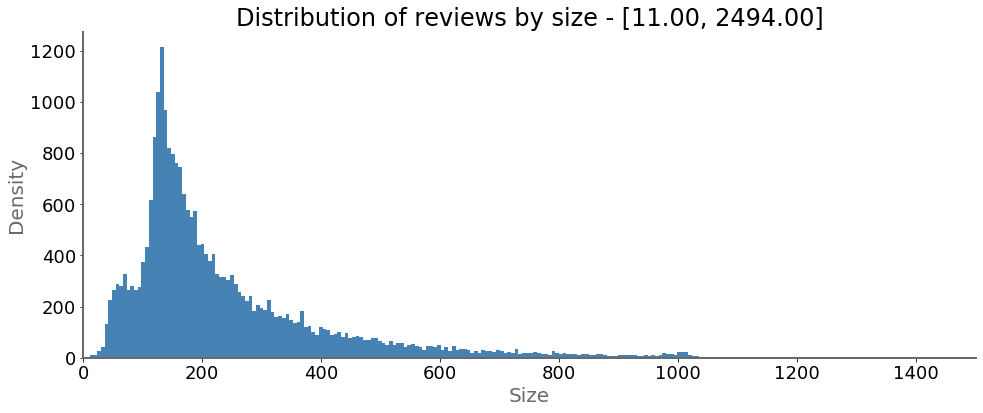

In [6]:
sizes=[len(i) for i in x_train]
plt.figure(figsize=(16,6))
plt.hist(sizes, bins=400)
plt.gca().set(title='Distribution of reviews by size - [{:5.2f}, {:5.2f}]'.format(min(sizes),max(sizes)), 
              xlabel='Size', ylabel='Density', xlim=[0,1500])
pwk.save_fig('01-stats-sizes')
plt.show()

## Step 3 - Preprocess the data (padding)
In order to be processed by an NN, all entries must have the **same length.**  
We chose a review length of **review_len**  
We will therefore complete them with a padding (of \<pad\>\)  

In [7]:
review_len = 256

x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                     value   = 0,
                                                     padding = 'post',
                                                     maxlen  = review_len)

x_test  = keras.preprocessing.sequence.pad_sequences(x_test,
                                                     value   = 0 ,
                                                     padding = 'post',
                                                     maxlen  = review_len)

pwk.subtitle('After padding :')
print(x_train[12])
pwk.subtitle('In real words :')
print(dataset2text(x_train[12]))

<br>**After padding :**

[   1   14   22 1367   53  206  159    4  636  898   74   26   11  436
  363  108    7   14  432   14   22    9 1055   34 8599    2    5  381
 3705 4509   14  768   47  839   25  111 1517 2579 1991  438 2663  587
    4  280  725    6   58   11 2714  201    4  206   16  702    5 5176
   19  480 5920  157   13   64  219    4    2   11  107  665 1212   39
    4  206    4   65  410   16  565    5   24   43  343   17 5602    8
  169  101   85  206  108    8 3008   14   25  215  168   18    6 2579
 1991  438    2   11  129 1609   36   26   66  290 3303   46    5  633
  115 4363    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

<br>**In real words :**

<start> this film contains more action before the opening credits than are in entire hollywood films of this sort this film is produced by tsui <unknown> and stars jet li this team has brought you many worthy hong kong cinema productions including the once upon a time in china series the action was fast and furious with amazing wire work i only saw the <unknown> in two shots aside from the action the story itself was strong and not just used as filler to find any other action films to rival this you must look for a hong kong cinema <unknown> in your area they are really worth checking out and usually never disappoint <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pa

**Save dataset and dictionary (For future use but not mandatory)**

In [8]:
# ---- Write dataset in a h5 file, could be usefull
#
output_dir = './data'
pwk.mkdir(output_dir)

with h5py.File(f'{output_dir}/dataset_imdb.h5', 'w') as f:
    f.create_dataset("x_train",    data=x_train)
    f.create_dataset("y_train",    data=y_train)
    f.create_dataset("x_test",     data=x_test)
    f.create_dataset("y_test",     data=y_test)

with open(f'{output_dir}/word_index.json', 'w') as fp:
    json.dump(word_index, fp)

with open(f'{output_dir}/index_word.json', 'w') as fp:
    json.dump(index_word, fp)

print('Saved.')

Saved.


## Step 4 - Build the model
Few remarks :
 - We'll choose a dense vector size for the embedding output with **dense_vector_size**
 - **GlobalAveragePooling1D** do a pooling on the last dimension : (None, lx, ly) -> (None, ly)  
   In other words: we average the set of vectors/words of a sentence
 - L'embedding de Keras fonctionne de manière supervisée. Il s'agit d'une couche de *vocab_size* neurones vers *n_neurons* permettant de maintenir une table de vecteurs (les poids constituent les vecteurs). Cette couche ne calcule pas de sortie a la façon des couches normales, mais renvois la valeur des vecteurs. n mots => n vecteurs (ensuite empilés par le pooling)  
Voir : [Explication plus détaillée (en)](https://stats.stackexchange.com/questions/324992/how-the-embedding-layer-is-trained-in-keras-embedding-layer)  
ainsi que : [Sentiment detection with Keras](https://www.liip.ch/en/blog/sentiment-detection-with-keras-word-embeddings-and-lstm-deep-learning-networks)  

More documentation about this model functions :
 - [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)
 - [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D)

In [9]:
def get_model(dense_vector_size=32):
    
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim    = vocab_size, 
                                     output_dim   = dense_vector_size, 
                                     input_length = review_len))
    model.add(keras.layers.GlobalAveragePooling1D())
    model.add(keras.layers.Dense(dense_vector_size, activation='relu'))
    model.add(keras.layers.Dense(1,                 activation='sigmoid'))

    model.compile(optimizer = 'adam',
                  loss      = 'binary_crossentropy',
                  metrics   = ['accuracy'])
    return model

## Step 5 - Train the model
### 5.1 - Get it

In [10]:
model = get_model(32)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 32)           320000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 321,089
Trainable params: 321,089
Non-trainable params: 0
_________________________________________________________________


### 5.2 - Add callback

In [11]:
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_model.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 5.1 - Train it

In [12]:
%%time

n_epochs   = 30
batch_size = 512

history = model.fit(x_train,
                    y_train,
                    epochs          = n_epochs,
                    batch_size      = batch_size,
                    validation_data = (x_test, y_test),
                    verbose         = 1,
                    callbacks       = [savemodel_callback])


Epoch 1/30


 1/49 [..............................] - ETA: 0s - loss: 0.6932 - accuracy: 0.4922

 5/49 [==>...........................] - ETA: 0s - loss: 0.6930 - accuracy: 0.5102

10/49 [=====>........................] - ETA: 0s - loss: 0.6929 - accuracy: 0.5086

15/49 [========>.....................] - ETA: 0s - loss: 0.6926 - accuracy: 0.5057

20/49 [===========>..................] - ETA: 0s - loss: 0.6924 - accuracy: 0.5077

25/49 [==============>...............] - ETA: 0s - loss: 0.6921 - accuracy: 0.5234

30/49 [=================>............] - ETA: 0s - loss: 0.6918 - accuracy: 0.5454

35/49 [====================>.........] - ETA: 0s - loss: 0.6913 - accuracy: 0.5673

40/49 [=======================>......] - ETA: 0s - loss: 0.6908 - accuracy: 0.5856

45/49 [==========================>...] - ETA: 0s - loss: 0.6901 - accuracy: 0.5997

49/49 [==============================] - 1s 21ms/step - loss: 0.6895 - accuracy: 0.6074 - val_loss: 0.6810 - val_accuracy: 0.6930


Epoch 2/30
 1/49 [..............................] - ETA: 0s - loss: 0.6783 - accuracy: 0.7363

 6/49 [==>...........................] - ETA: 0s - loss: 0.6774 - accuracy: 0.7064

11/49 [=====>........................] - ETA: 0s - loss: 0.6757 - accuracy: 0.7053

16/49 [========>.....................] - ETA: 0s - loss: 0.6736 - accuracy: 0.7100

21/49 [===========>..................] - ETA: 0s - loss: 0.6717 - accuracy: 0.7133

26/49 [==============>...............] - ETA: 0s - loss: 0.6687 - accuracy: 0.7197

31/49 [=================>............] - ETA: 0s - loss: 0.6664 - accuracy: 0.7208

36/49 [=====================>........] - ETA: 0s - loss: 0.6633 - accuracy: 0.7261

41/49 [========================>.....] - ETA: 0s - loss: 0.6604 - accuracy: 0.7302

46/49 [===========================>..] - ETA: 0s - loss: 0.6571 - accuracy: 0.7352

49/49 [==============================] - 1s 16ms/step - loss: 0.6553 - accuracy: 0.7371 - val_loss: 0.6219 - val_accuracy: 0.7731


Epoch 3/30
 1/49 [..............................] - ETA: 0s - loss: 0.6185 - accuracy: 0.7773

 6/49 [==>...........................] - ETA: 0s - loss: 0.6123 - accuracy: 0.7721

11/49 [=====>........................] - ETA: 0s - loss: 0.6079 - accuracy: 0.7777

16/49 [========>.....................] - ETA: 0s - loss: 0.6023 - accuracy: 0.7850

21/49 [===========>..................] - ETA: 0s - loss: 0.5971 - accuracy: 0.7887

26/49 [==============>...............] - ETA: 0s - loss: 0.5913 - accuracy: 0.7904

31/49 [=================>............] - ETA: 0s - loss: 0.5847 - accuracy: 0.7953

36/49 [=====================>........] - ETA: 0s - loss: 0.5783 - accuracy: 0.7977

41/49 [========================>.....] - ETA: 0s - loss: 0.5716 - accuracy: 0.8019

46/49 [===========================>..] - ETA: 0s - loss: 0.5662 - accuracy: 0.8033

49/49 [==============================] - 1s 16ms/step - loss: 0.5625 - accuracy: 0.8056 - val_loss: 0.5145 - val_accuracy: 0.8172


Epoch 4/30
 1/49 [..............................] - ETA: 0s - loss: 0.4941 - accuracy: 0.8418

 6/49 [==>...........................] - ETA: 0s - loss: 0.4920 - accuracy: 0.8327

11/49 [=====>........................] - ETA: 0s - loss: 0.4844 - accuracy: 0.8356

16/49 [========>.....................] - ETA: 0s - loss: 0.4812 - accuracy: 0.8386

21/49 [===========>..................] - ETA: 0s - loss: 0.4766 - accuracy: 0.8373

26/49 [==============>...............] - ETA: 0s - loss: 0.4707 - accuracy: 0.8387

31/49 [=================>............] - ETA: 0s - loss: 0.4650 - accuracy: 0.8432

36/49 [=====================>........] - ETA: 0s - loss: 0.4597 - accuracy: 0.8443

41/49 [========================>.....] - ETA: 0s - loss: 0.4553 - accuracy: 0.8448

46/49 [===========================>..] - ETA: 0s - loss: 0.4496 - accuracy: 0.8469

49/49 [==============================] - 1s 15ms/step - loss: 0.4466 - accuracy: 0.8478 - val_loss: 0.4195 - val_accuracy: 0.8465


Epoch 5/30
 1/49 [..............................] - ETA: 0s - loss: 0.4059 - accuracy: 0.8594

 6/49 [==>...........................] - ETA: 0s - loss: 0.3811 - accuracy: 0.8743

11/49 [=====>........................] - ETA: 0s - loss: 0.3845 - accuracy: 0.8670

16/49 [========>.....................] - ETA: 0s - loss: 0.3776 - accuracy: 0.8722

21/49 [===========>..................] - ETA: 0s - loss: 0.3739 - accuracy: 0.8715

26/49 [==============>...............] - ETA: 0s - loss: 0.3723 - accuracy: 0.8710

31/49 [=================>............] - ETA: 0s - loss: 0.3697 - accuracy: 0.8716

36/49 [=====================>........] - ETA: 0s - loss: 0.3658 - accuracy: 0.8726

41/49 [========================>.....] - ETA: 0s - loss: 0.3641 - accuracy: 0.8728

46/49 [===========================>..] - ETA: 0s - loss: 0.3614 - accuracy: 0.8736

49/49 [==============================] - 1s 15ms/step - loss: 0.3595 - accuracy: 0.8745 - val_loss: 0.3626 - val_accuracy: 0.8596


Epoch 6/30
 1/49 [..............................] - ETA: 0s - loss: 0.3058 - accuracy: 0.8926

 6/49 [==>...........................] - ETA: 0s - loss: 0.3108 - accuracy: 0.8929

11/49 [=====>........................] - ETA: 0s - loss: 0.3181 - accuracy: 0.8880

16/49 [========>.....................] - ETA: 0s - loss: 0.3185 - accuracy: 0.8860

21/49 [===========>..................] - ETA: 0s - loss: 0.3162 - accuracy: 0.8876

26/49 [==============>...............] - ETA: 0s - loss: 0.3149 - accuracy: 0.8878

31/49 [=================>............] - ETA: 0s - loss: 0.3122 - accuracy: 0.8893

36/49 [=====================>........] - ETA: 0s - loss: 0.3096 - accuracy: 0.8899

41/49 [========================>.....] - ETA: 0s - loss: 0.3081 - accuracy: 0.8901

46/49 [===========================>..] - ETA: 0s - loss: 0.3074 - accuracy: 0.8896

49/49 [==============================] - 1s 15ms/step - loss: 0.3058 - accuracy: 0.8904 - val_loss: 0.3308 - val_accuracy: 0.8681


Epoch 7/30
 1/49 [..............................] - ETA: 0s - loss: 0.2746 - accuracy: 0.9141

 6/49 [==>...........................] - ETA: 0s - loss: 0.2704 - accuracy: 0.9082

11/49 [=====>........................] - ETA: 0s - loss: 0.2766 - accuracy: 0.9032

16/49 [========>.....................] - ETA: 0s - loss: 0.2763 - accuracy: 0.9011

21/49 [===========>..................] - ETA: 0s - loss: 0.2738 - accuracy: 0.9009

26/49 [==============>...............] - ETA: 0s - loss: 0.2741 - accuracy: 0.9002

31/49 [=================>............] - ETA: 0s - loss: 0.2712 - accuracy: 0.9015

36/49 [=====================>........] - ETA: 0s - loss: 0.2712 - accuracy: 0.9015

41/49 [========================>.....] - ETA: 0s - loss: 0.2711 - accuracy: 0.9017

46/49 [===========================>..] - ETA: 0s - loss: 0.2707 - accuracy: 0.9017

49/49 [==============================] - 1s 15ms/step - loss: 0.2704 - accuracy: 0.9011 - val_loss: 0.3119 - val_accuracy: 0.8734


Epoch 8/30
 1/49 [..............................] - ETA: 0s - loss: 0.2302 - accuracy: 0.9199

 6/49 [==>...........................] - ETA: 0s - loss: 0.2501 - accuracy: 0.9072

11/49 [=====>........................] - ETA: 0s - loss: 0.2491 - accuracy: 0.9084

16/49 [========>.....................] - ETA: 0s - loss: 0.2523 - accuracy: 0.9065

21/49 [===========>..................] - ETA: 0s - loss: 0.2515 - accuracy: 0.9062

26/49 [==============>...............] - ETA: 0s - loss: 0.2524 - accuracy: 0.9053

31/49 [=================>............] - ETA: 0s - loss: 0.2496 - accuracy: 0.9073

36/49 [=====================>........] - ETA: 0s - loss: 0.2470 - accuracy: 0.9088

41/49 [========================>.....] - ETA: 0s - loss: 0.2462 - accuracy: 0.9092

46/49 [===========================>..] - ETA: 0s - loss: 0.2460 - accuracy: 0.9092

49/49 [==============================] - 1s 16ms/step - loss: 0.2451 - accuracy: 0.9096 - val_loss: 0.3006 - val_accuracy: 0.8762


Epoch 9/30
 1/49 [..............................] - ETA: 0s - loss: 0.2303 - accuracy: 0.9180

 6/49 [==>...........................] - ETA: 0s - loss: 0.2244 - accuracy: 0.9183

11/49 [=====>........................] - ETA: 0s - loss: 0.2228 - accuracy: 0.9174

16/49 [========>.....................] - ETA: 0s - loss: 0.2232 - accuracy: 0.9192

21/49 [===========>..................] - ETA: 0s - loss: 0.2202 - accuracy: 0.9210

26/49 [==============>...............] - ETA: 0s - loss: 0.2215 - accuracy: 0.9189

31/49 [=================>............] - ETA: 0s - loss: 0.2225 - accuracy: 0.9207

36/49 [=====================>........] - ETA: 0s - loss: 0.2246 - accuracy: 0.9193

41/49 [========================>.....] - ETA: 0s - loss: 0.2237 - accuracy: 0.9200

46/49 [===========================>..] - ETA: 0s - loss: 0.2242 - accuracy: 0.9187

49/49 [==============================] - 1s 16ms/step - loss: 0.2243 - accuracy: 0.9184 - val_loss: 0.2929 - val_accuracy: 0.8793


Epoch 10/30
 1/49 [..............................] - ETA: 0s - loss: 0.1832 - accuracy: 0.9395

 6/49 [==>...........................] - ETA: 0s - loss: 0.2060 - accuracy: 0.9264

11/49 [=====>........................] - ETA: 0s - loss: 0.2125 - accuracy: 0.9249

16/49 [========>.....................] - ETA: 0s - loss: 0.2091 - accuracy: 0.9264

21/49 [===========>..................] - ETA: 0s - loss: 0.2068 - accuracy: 0.9263

26/49 [==============>...............] - ETA: 0s - loss: 0.2082 - accuracy: 0.9264

31/49 [=================>............] - ETA: 0s - loss: 0.2079 - accuracy: 0.9264

36/49 [=====================>........] - ETA: 0s - loss: 0.2090 - accuracy: 0.9249

41/49 [========================>.....] - ETA: 0s - loss: 0.2081 - accuracy: 0.9251

46/49 [===========================>..] - ETA: 0s - loss: 0.2077 - accuracy: 0.9252

49/49 [==============================] - 1s 15ms/step - loss: 0.2074 - accuracy: 0.9256 - val_loss: 0.2886 - val_accuracy: 0.8819


Epoch 11/30
 1/49 [..............................] - ETA: 0s - loss: 0.2104 - accuracy: 0.9258

 6/49 [==>...........................] - ETA: 0s - loss: 0.1951 - accuracy: 0.9307

11/49 [=====>........................] - ETA: 0s - loss: 0.1950 - accuracy: 0.9306

16/49 [========>.....................] - ETA: 0s - loss: 0.1917 - accuracy: 0.9325

21/49 [===========>..................] - ETA: 0s - loss: 0.1905 - accuracy: 0.9334

26/49 [==============>...............] - ETA: 0s - loss: 0.1924 - accuracy: 0.9330

31/49 [=================>............] - ETA: 0s - loss: 0.1941 - accuracy: 0.9313

36/49 [=====================>........] - ETA: 0s - loss: 0.1934 - accuracy: 0.9314

41/49 [========================>.....] - ETA: 0s - loss: 0.1940 - accuracy: 0.9309

46/49 [===========================>..] - ETA: 0s - loss: 0.1928 - accuracy: 0.9310

49/49 [==============================] - 1s 15ms/step - loss: 0.1927 - accuracy: 0.9306 - val_loss: 0.2876 - val_accuracy: 0.8826


Epoch 12/30
 1/49 [..............................] - ETA: 0s - loss: 0.1854 - accuracy: 0.9355

 6/49 [==>...........................] - ETA: 0s - loss: 0.1902 - accuracy: 0.9323

11/49 [=====>........................] - ETA: 0s - loss: 0.1854 - accuracy: 0.9332

16/49 [========>.....................] - ETA: 0s - loss: 0.1836 - accuracy: 0.9349

21/49 [===========>..................] - ETA: 0s - loss: 0.1864 - accuracy: 0.9335

26/49 [==============>...............] - ETA: 0s - loss: 0.1830 - accuracy: 0.9349

31/49 [=================>............] - ETA: 0s - loss: 0.1820 - accuracy: 0.9352

36/49 [=====================>........] - ETA: 0s - loss: 0.1817 - accuracy: 0.9357

41/49 [========================>.....] - ETA: 0s - loss: 0.1822 - accuracy: 0.9352

46/49 [===========================>..] - ETA: 0s - loss: 0.1800 - accuracy: 0.9368

49/49 [==============================] - 1s 16ms/step - loss: 0.1806 - accuracy: 0.9363 - val_loss: 0.2868 - val_accuracy: 0.8829


Epoch 13/30
 1/49 [..............................] - ETA: 0s - loss: 0.1516 - accuracy: 0.9609

 6/49 [==>...........................] - ETA: 0s - loss: 0.1678 - accuracy: 0.9463

11/49 [=====>........................] - ETA: 0s - loss: 0.1741 - accuracy: 0.9416

16/49 [========>.....................] - ETA: 0s - loss: 0.1708 - accuracy: 0.9426

21/49 [===========>..................] - ETA: 0s - loss: 0.1704 - accuracy: 0.9412

26/49 [==============>...............] - ETA: 0s - loss: 0.1707 - accuracy: 0.9409

31/49 [=================>............] - ETA: 0s - loss: 0.1731 - accuracy: 0.9392

36/49 [=====================>........] - ETA: 0s - loss: 0.1702 - accuracy: 0.9405

41/49 [========================>.....] - ETA: 0s - loss: 0.1693 - accuracy: 0.9406

46/49 [===========================>..] - ETA: 0s - loss: 0.1699 - accuracy: 0.9410

49/49 [==============================] - 1s 15ms/step - loss: 0.1700 - accuracy: 0.9406 - val_loss: 0.2885 - val_accuracy: 0.8832


Epoch 14/30
 1/49 [..............................] - ETA: 0s - loss: 0.1392 - accuracy: 0.9531

 6/49 [==>...........................] - ETA: 0s - loss: 0.1684 - accuracy: 0.9391

11/49 [=====>........................] - ETA: 0s - loss: 0.1682 - accuracy: 0.9418

16/49 [========>.....................] - ETA: 0s - loss: 0.1636 - accuracy: 0.9446

21/49 [===========>..................] - ETA: 0s - loss: 0.1611 - accuracy: 0.9454

26/49 [==============>...............] - ETA: 0s - loss: 0.1608 - accuracy: 0.9454

31/49 [=================>............] - ETA: 0s - loss: 0.1599 - accuracy: 0.9454

36/49 [=====================>........] - ETA: 0s - loss: 0.1586 - accuracy: 0.9460

41/49 [========================>.....] - ETA: 0s - loss: 0.1599 - accuracy: 0.9448

46/49 [===========================>..] - ETA: 0s - loss: 0.1598 - accuracy: 0.9448

49/49 [==============================] - 1s 15ms/step - loss: 0.1597 - accuracy: 0.9450 - val_loss: 0.2914 - val_accuracy: 0.8818


Epoch 15/30
 1/49 [..............................] - ETA: 0s - loss: 0.1739 - accuracy: 0.9414

 6/49 [==>...........................] - ETA: 0s - loss: 0.1515 - accuracy: 0.9486

11/49 [=====>........................] - ETA: 0s - loss: 0.1496 - accuracy: 0.9489

16/49 [========>.....................] - ETA: 0s - loss: 0.1501 - accuracy: 0.9495

21/49 [===========>..................] - ETA: 0s - loss: 0.1516 - accuracy: 0.9482

26/49 [==============>...............] - ETA: 0s - loss: 0.1508 - accuracy: 0.9486

31/49 [=================>............] - ETA: 0s - loss: 0.1500 - accuracy: 0.9490

36/49 [=====================>........] - ETA: 0s - loss: 0.1504 - accuracy: 0.9491

41/49 [========================>.....] - ETA: 0s - loss: 0.1499 - accuracy: 0.9494

46/49 [===========================>..] - ETA: 0s - loss: 0.1503 - accuracy: 0.9498

49/49 [==============================] - 1s 15ms/step - loss: 0.1510 - accuracy: 0.9493 - val_loss: 0.2951 - val_accuracy: 0.8821


Epoch 16/30
 1/49 [..............................] - ETA: 0s - loss: 0.1296 - accuracy: 0.9629

 6/49 [==>...........................] - ETA: 0s - loss: 0.1447 - accuracy: 0.9551

11/49 [=====>........................] - ETA: 0s - loss: 0.1482 - accuracy: 0.9508

16/49 [========>.....................] - ETA: 0s - loss: 0.1470 - accuracy: 0.9514

21/49 [===========>..................] - ETA: 0s - loss: 0.1464 - accuracy: 0.9515

26/49 [==============>...............] - ETA: 0s - loss: 0.1434 - accuracy: 0.9530

30/49 [=================>............] - ETA: 0s - loss: 0.1432 - accuracy: 0.9533

35/49 [====================>.........] - ETA: 0s - loss: 0.1435 - accuracy: 0.9522

40/49 [=======================>......] - ETA: 0s - loss: 0.1429 - accuracy: 0.9522

45/49 [==========================>...] - ETA: 0s - loss: 0.1438 - accuracy: 0.9516

49/49 [==============================] - 1s 15ms/step - loss: 0.1429 - accuracy: 0.9520 - val_loss: 0.2993 - val_accuracy: 0.8816


Epoch 17/30
 1/49 [..............................] - ETA: 0s - loss: 0.1843 - accuracy: 0.9336

 6/49 [==>...........................] - ETA: 0s - loss: 0.1555 - accuracy: 0.9450

11/49 [=====>........................] - ETA: 0s - loss: 0.1425 - accuracy: 0.9533

16/49 [========>.....................] - ETA: 0s - loss: 0.1391 - accuracy: 0.9540

21/49 [===========>..................] - ETA: 0s - loss: 0.1376 - accuracy: 0.9545

26/49 [==============>...............] - ETA: 0s - loss: 0.1386 - accuracy: 0.9535

31/49 [=================>............] - ETA: 0s - loss: 0.1383 - accuracy: 0.9543

36/49 [=====================>........] - ETA: 0s - loss: 0.1380 - accuracy: 0.9535

41/49 [========================>.....] - ETA: 0s - loss: 0.1364 - accuracy: 0.9545

46/49 [===========================>..] - ETA: 0s - loss: 0.1353 - accuracy: 0.9552

49/49 [==============================] - 1s 15ms/step - loss: 0.1354 - accuracy: 0.9553 - val_loss: 0.3049 - val_accuracy: 0.8809


Epoch 18/30
 1/49 [..............................] - ETA: 0s - loss: 0.1354 - accuracy: 0.9570

 6/49 [==>...........................] - ETA: 0s - loss: 0.1307 - accuracy: 0.9587

11/49 [=====>........................] - ETA: 0s - loss: 0.1305 - accuracy: 0.9590

16/49 [========>.....................] - ETA: 0s - loss: 0.1307 - accuracy: 0.9598

21/49 [===========>..................] - ETA: 0s - loss: 0.1279 - accuracy: 0.9604

26/49 [==============>...............] - ETA: 0s - loss: 0.1284 - accuracy: 0.9594

31/49 [=================>............] - ETA: 0s - loss: 0.1295 - accuracy: 0.9594

36/49 [=====================>........] - ETA: 0s - loss: 0.1297 - accuracy: 0.9589

41/49 [========================>.....] - ETA: 0s - loss: 0.1295 - accuracy: 0.9586

46/49 [===========================>..] - ETA: 0s - loss: 0.1296 - accuracy: 0.9583

49/49 [==============================] - 1s 15ms/step - loss: 0.1292 - accuracy: 0.9582 - val_loss: 0.3146 - val_accuracy: 0.8760


Epoch 19/30
 1/49 [..............................] - ETA: 0s - loss: 0.1055 - accuracy: 0.9590

 6/49 [==>...........................] - ETA: 0s - loss: 0.1161 - accuracy: 0.9593

11/49 [=====>........................] - ETA: 0s - loss: 0.1204 - accuracy: 0.9604

16/49 [========>.....................] - ETA: 0s - loss: 0.1202 - accuracy: 0.9602

21/49 [===========>..................] - ETA: 0s - loss: 0.1181 - accuracy: 0.9621

26/49 [==============>...............] - ETA: 0s - loss: 0.1186 - accuracy: 0.9618

31/49 [=================>............] - ETA: 0s - loss: 0.1189 - accuracy: 0.9620

36/49 [=====================>........] - ETA: 0s - loss: 0.1204 - accuracy: 0.9610

41/49 [========================>.....] - ETA: 0s - loss: 0.1219 - accuracy: 0.9610

46/49 [===========================>..] - ETA: 0s - loss: 0.1211 - accuracy: 0.9615

49/49 [==============================] - 1s 15ms/step - loss: 0.1216 - accuracy: 0.9610 - val_loss: 0.3177 - val_accuracy: 0.8780


Epoch 20/30
 1/49 [..............................] - ETA: 0s - loss: 0.0970 - accuracy: 0.9668

 6/49 [==>...........................] - ETA: 0s - loss: 0.1046 - accuracy: 0.9684

11/49 [=====>........................] - ETA: 0s - loss: 0.1038 - accuracy: 0.9705

16/49 [========>.....................] - ETA: 0s - loss: 0.1079 - accuracy: 0.9675

21/49 [===========>..................] - ETA: 0s - loss: 0.1131 - accuracy: 0.9660

26/49 [==============>...............] - ETA: 0s - loss: 0.1141 - accuracy: 0.9651

31/49 [=================>............] - ETA: 0s - loss: 0.1141 - accuracy: 0.9643

36/49 [=====================>........] - ETA: 0s - loss: 0.1137 - accuracy: 0.9646

41/49 [========================>.....] - ETA: 0s - loss: 0.1150 - accuracy: 0.9641

46/49 [===========================>..] - ETA: 0s - loss: 0.1151 - accuracy: 0.9640

49/49 [==============================] - 1s 15ms/step - loss: 0.1157 - accuracy: 0.9634 - val_loss: 0.3252 - val_accuracy: 0.8761


Epoch 21/30
 1/49 [..............................] - ETA: 0s - loss: 0.0964 - accuracy: 0.9629

 6/49 [==>...........................] - ETA: 0s - loss: 0.1189 - accuracy: 0.9635

11/49 [=====>........................] - ETA: 0s - loss: 0.1148 - accuracy: 0.9632

16/49 [========>.....................] - ETA: 0s - loss: 0.1102 - accuracy: 0.9657

21/49 [===========>..................] - ETA: 0s - loss: 0.1116 - accuracy: 0.9644

26/49 [==============>...............] - ETA: 0s - loss: 0.1094 - accuracy: 0.9651

31/49 [=================>............] - ETA: 0s - loss: 0.1067 - accuracy: 0.9664

36/49 [=====================>........] - ETA: 0s - loss: 0.1074 - accuracy: 0.9666

41/49 [========================>.....] - ETA: 0s - loss: 0.1084 - accuracy: 0.9670

46/49 [===========================>..] - ETA: 0s - loss: 0.1101 - accuracy: 0.9659

49/49 [==============================] - 1s 15ms/step - loss: 0.1104 - accuracy: 0.9659 - val_loss: 0.3341 - val_accuracy: 0.8756


Epoch 22/30
 1/49 [..............................] - ETA: 0s - loss: 0.0881 - accuracy: 0.9688

 6/49 [==>...........................] - ETA: 0s - loss: 0.0993 - accuracy: 0.9671

11/49 [=====>........................] - ETA: 0s - loss: 0.1024 - accuracy: 0.9696

16/49 [========>.....................] - ETA: 0s - loss: 0.1032 - accuracy: 0.9694

21/49 [===========>..................] - ETA: 0s - loss: 0.1019 - accuracy: 0.9699

26/49 [==============>...............] - ETA: 0s - loss: 0.1008 - accuracy: 0.9700

31/49 [=================>............] - ETA: 0s - loss: 0.1008 - accuracy: 0.9697

36/49 [=====================>........] - ETA: 0s - loss: 0.1025 - accuracy: 0.9683

41/49 [========================>.....] - ETA: 0s - loss: 0.1033 - accuracy: 0.9687

46/49 [===========================>..] - ETA: 0s - loss: 0.1043 - accuracy: 0.9684

49/49 [==============================] - 1s 15ms/step - loss: 0.1052 - accuracy: 0.9679 - val_loss: 0.3419 - val_accuracy: 0.8748


Epoch 23/30
 1/49 [..............................] - ETA: 0s - loss: 0.0926 - accuracy: 0.9766

 6/49 [==>...........................] - ETA: 0s - loss: 0.1000 - accuracy: 0.9710

11/49 [=====>........................] - ETA: 0s - loss: 0.0996 - accuracy: 0.9727

16/49 [========>.....................] - ETA: 0s - loss: 0.0993 - accuracy: 0.9714

21/49 [===========>..................] - ETA: 0s - loss: 0.1006 - accuracy: 0.9707

26/49 [==============>...............] - ETA: 0s - loss: 0.0993 - accuracy: 0.9705

31/49 [=================>............] - ETA: 0s - loss: 0.0987 - accuracy: 0.9703

36/49 [=====================>........] - ETA: 0s - loss: 0.1004 - accuracy: 0.9703

41/49 [========================>.....] - ETA: 0s - loss: 0.1012 - accuracy: 0.9700

46/49 [===========================>..] - ETA: 0s - loss: 0.1010 - accuracy: 0.9697

49/49 [==============================] - 1s 15ms/step - loss: 0.1009 - accuracy: 0.9696 - val_loss: 0.3525 - val_accuracy: 0.8702


Epoch 24/30
 1/49 [..............................] - ETA: 0s - loss: 0.0978 - accuracy: 0.9746

 6/49 [==>...........................] - ETA: 0s - loss: 0.0957 - accuracy: 0.9749

11/49 [=====>........................] - ETA: 0s - loss: 0.0930 - accuracy: 0.9762

16/49 [========>.....................] - ETA: 0s - loss: 0.0915 - accuracy: 0.9760

21/49 [===========>..................] - ETA: 0s - loss: 0.0927 - accuracy: 0.9749

26/49 [==============>...............] - ETA: 0s - loss: 0.0935 - accuracy: 0.9743

31/49 [=================>............] - ETA: 0s - loss: 0.0944 - accuracy: 0.9735

36/49 [=====================>........] - ETA: 0s - loss: 0.0941 - accuracy: 0.9736

41/49 [========================>.....] - ETA: 0s - loss: 0.0951 - accuracy: 0.9728

46/49 [===========================>..] - ETA: 0s - loss: 0.0965 - accuracy: 0.9723

49/49 [==============================] - 1s 15ms/step - loss: 0.0964 - accuracy: 0.9725 - val_loss: 0.3597 - val_accuracy: 0.8705


Epoch 25/30
 1/49 [..............................] - ETA: 0s - loss: 0.0930 - accuracy: 0.9766

 6/49 [==>...........................] - ETA: 0s - loss: 0.0966 - accuracy: 0.9707

11/49 [=====>........................] - ETA: 0s - loss: 0.0987 - accuracy: 0.9698

16/49 [========>.....................] - ETA: 0s - loss: 0.0935 - accuracy: 0.9718

21/49 [===========>..................] - ETA: 0s - loss: 0.0934 - accuracy: 0.9722

26/49 [==============>...............] - ETA: 0s - loss: 0.0958 - accuracy: 0.9723

31/49 [=================>............] - ETA: 0s - loss: 0.0931 - accuracy: 0.9733

36/49 [=====================>........] - ETA: 0s - loss: 0.0919 - accuracy: 0.9738

41/49 [========================>.....] - ETA: 0s - loss: 0.0924 - accuracy: 0.9733

46/49 [===========================>..] - ETA: 0s - loss: 0.0916 - accuracy: 0.9734

49/49 [==============================] - 1s 15ms/step - loss: 0.0919 - accuracy: 0.9737 - val_loss: 0.3673 - val_accuracy: 0.8700


Epoch 26/30
 1/49 [..............................] - ETA: 0s - loss: 0.0559 - accuracy: 0.9902

 6/49 [==>...........................] - ETA: 0s - loss: 0.0803 - accuracy: 0.9785

11/49 [=====>........................] - ETA: 0s - loss: 0.0846 - accuracy: 0.9771

16/49 [========>.....................] - ETA: 0s - loss: 0.0886 - accuracy: 0.9755

21/49 [===========>..................] - ETA: 0s - loss: 0.0880 - accuracy: 0.9755

26/49 [==============>...............] - ETA: 0s - loss: 0.0865 - accuracy: 0.9755

31/49 [=================>............] - ETA: 0s - loss: 0.0859 - accuracy: 0.9759

36/49 [=====================>........] - ETA: 0s - loss: 0.0857 - accuracy: 0.9749

41/49 [========================>.....] - ETA: 0s - loss: 0.0868 - accuracy: 0.9750

46/49 [===========================>..] - ETA: 0s - loss: 0.0878 - accuracy: 0.9747

49/49 [==============================] - 1s 15ms/step - loss: 0.0878 - accuracy: 0.9749 - val_loss: 0.3779 - val_accuracy: 0.8689


Epoch 27/30
 1/49 [..............................] - ETA: 0s - loss: 0.0913 - accuracy: 0.9707

 6/49 [==>...........................] - ETA: 0s - loss: 0.0813 - accuracy: 0.9769

11/49 [=====>........................] - ETA: 0s - loss: 0.0763 - accuracy: 0.9808

16/49 [========>.....................] - ETA: 0s - loss: 0.0780 - accuracy: 0.9794

21/49 [===========>..................] - ETA: 0s - loss: 0.0795 - accuracy: 0.9790

26/49 [==============>...............] - ETA: 0s - loss: 0.0812 - accuracy: 0.9787

31/49 [=================>............] - ETA: 0s - loss: 0.0810 - accuracy: 0.9786

36/49 [=====================>........] - ETA: 0s - loss: 0.0828 - accuracy: 0.9778

41/49 [========================>.....] - ETA: 0s - loss: 0.0821 - accuracy: 0.9780

46/49 [===========================>..] - ETA: 0s - loss: 0.0829 - accuracy: 0.9780

49/49 [==============================] - 1s 15ms/step - loss: 0.0828 - accuracy: 0.9780 - val_loss: 0.3864 - val_accuracy: 0.8679


Epoch 28/30
 1/49 [..............................] - ETA: 0s - loss: 0.1063 - accuracy: 0.9688

 6/49 [==>...........................] - ETA: 0s - loss: 0.0776 - accuracy: 0.9782

11/49 [=====>........................] - ETA: 0s - loss: 0.0738 - accuracy: 0.9805

16/49 [========>.....................] - ETA: 0s - loss: 0.0744 - accuracy: 0.9794

21/49 [===========>..................] - ETA: 0s - loss: 0.0749 - accuracy: 0.9803

26/49 [==============>...............] - ETA: 0s - loss: 0.0764 - accuracy: 0.9796

31/49 [=================>............] - ETA: 0s - loss: 0.0762 - accuracy: 0.9798

36/49 [=====================>........] - ETA: 0s - loss: 0.0770 - accuracy: 0.9798

41/49 [========================>.....] - ETA: 0s - loss: 0.0796 - accuracy: 0.9791

46/49 [===========================>..] - ETA: 0s - loss: 0.0792 - accuracy: 0.9790

49/49 [==============================] - 1s 15ms/step - loss: 0.0793 - accuracy: 0.9790 - val_loss: 0.3979 - val_accuracy: 0.8661


Epoch 29/30
 1/49 [..............................] - ETA: 0s - loss: 0.0693 - accuracy: 0.9844

 6/49 [==>...........................] - ETA: 0s - loss: 0.0714 - accuracy: 0.9831

11/49 [=====>........................] - ETA: 0s - loss: 0.0736 - accuracy: 0.9815

16/49 [========>.....................] - ETA: 0s - loss: 0.0742 - accuracy: 0.9806

21/49 [===========>..................] - ETA: 0s - loss: 0.0713 - accuracy: 0.9818

26/49 [==============>...............] - ETA: 0s - loss: 0.0742 - accuracy: 0.9813

31/49 [=================>............] - ETA: 0s - loss: 0.0753 - accuracy: 0.9807

36/49 [=====================>........] - ETA: 0s - loss: 0.0758 - accuracy: 0.9813

41/49 [========================>.....] - ETA: 0s - loss: 0.0759 - accuracy: 0.9810

46/49 [===========================>..] - ETA: 0s - loss: 0.0751 - accuracy: 0.9812

49/49 [==============================] - 1s 15ms/step - loss: 0.0758 - accuracy: 0.9808 - val_loss: 0.4075 - val_accuracy: 0.8643


Epoch 30/30
 1/49 [..............................] - ETA: 0s - loss: 0.0806 - accuracy: 0.9688

 6/49 [==>...........................] - ETA: 0s - loss: 0.0816 - accuracy: 0.9759

11/49 [=====>........................] - ETA: 0s - loss: 0.0728 - accuracy: 0.9803

16/49 [========>.....................] - ETA: 0s - loss: 0.0714 - accuracy: 0.9821

21/49 [===========>..................] - ETA: 0s - loss: 0.0728 - accuracy: 0.9815

26/49 [==============>...............] - ETA: 0s - loss: 0.0727 - accuracy: 0.9817

31/49 [=================>............] - ETA: 0s - loss: 0.0731 - accuracy: 0.9817

36/49 [=====================>........] - ETA: 0s - loss: 0.0723 - accuracy: 0.9821

41/49 [========================>.....] - ETA: 0s - loss: 0.0716 - accuracy: 0.9824

46/49 [===========================>..] - ETA: 0s - loss: 0.0724 - accuracy: 0.9820

49/49 [==============================] - 1s 15ms/step - loss: 0.0723 - accuracy: 0.9817 - val_loss: 0.4164 - val_accuracy: 0.8639


CPU times: user 47.1 s, sys: 3.79 s, total: 50.9 s
Wall time: 24.3 s


## Step 6 - Evaluate
### 6.1 - Training history

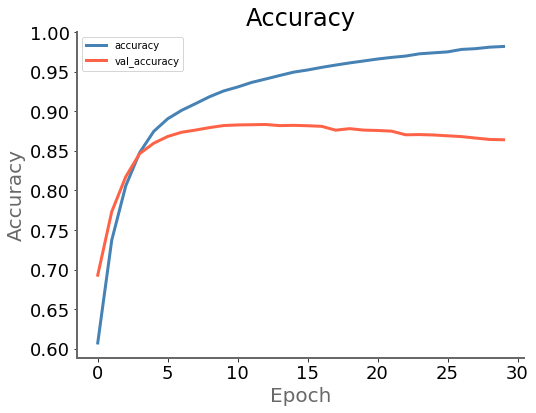

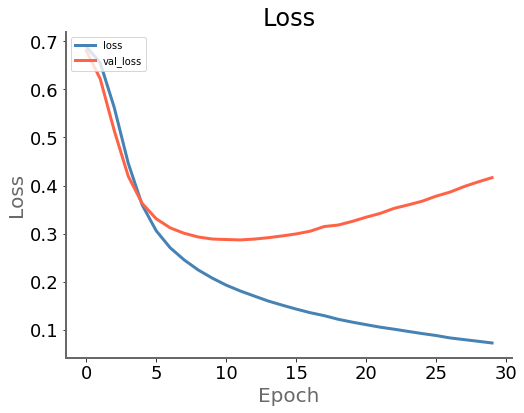

In [13]:
pwk.plot_history(history, save_as='02-history')

### 6.2 - Reload and evaluate best model

x_test / loss      : 0.2868
x_test / accuracy  : 0.8829


#### Accuracy donut is :

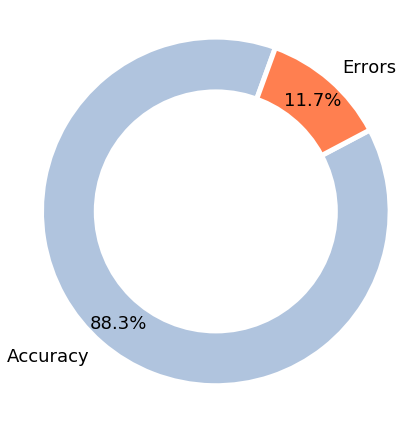

#### Confusion matrix is :

,0,1
0,0.88,0.12
1,0.12,0.88


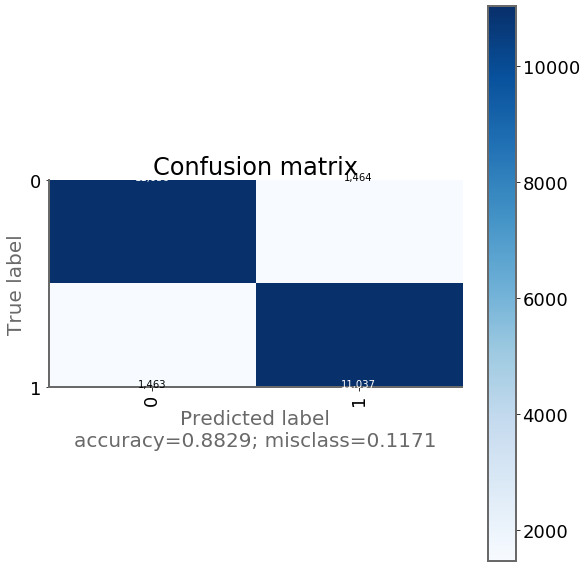

In [14]:
model = keras.models.load_model('./run/models/best_model.h5')

# ---- Evaluate
score  = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / accuracy  : {:5.4f}'.format(score[1]))

values=[score[1], 1-score[1]]
pwk.plot_donut(values,["Accuracy","Errors"], title="#### Accuracy donut is :", save_as='03-donut')

# ---- Confusion matrix

y_sigmoid = model.predict(x_test)

y_pred = y_sigmoid.copy()
y_pred[ y_sigmoid< 0.5 ] = 0
y_pred[ y_sigmoid>=0.5 ] = 1    

pwk.display_confusion_matrix(y_test,y_pred,labels=range(2))
pwk.plot_confusion_matrix(y_test,y_pred,range(2), figsize=(8, 8),normalize=False, save_as='04-confusion-matrix')

In [15]:
pwk.end()

End time is : Wednesday 27 January 2021, 19:12:08
Duration is : 00:00:46 511ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>